### Define Folder Paths

### Function to Load Images and Labels

In [177]:
import os
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.data import Dataset
from sklearn.model_selection import train_test_split

# ✅ Define Class Mapping
class_mapping = {
    "mult_mode_1": 0,
    "mult_mode_2": 1
}

# ✅ Function to Load Images with Error Handling
def load_images_from_folders(folder_paths, img_size=(256, 256)):
    images = []
    labels = []
    
    for class_name, folders in folder_paths.items():
        class_label = class_mapping[class_name]
        
        for folder in folders:
            if not os.path.exists(folder):
                print(f"Warning: Folder {folder} does not exist!")
                continue

            for img_name in os.listdir(folder):
                img_path = os.path.join(folder, img_name)
                
                try:
                    # Read image as grayscale
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"Skipping corrupted image: {img_path}")
                        continue  # Skip corrupted images

                    img = cv2.resize(img, img_size)  # Resize to 256x256
                    img = img / 255.0  # Normalize pixel values
                
                    images.append(img)
                    labels.append(class_label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    # Convert to NumPy arrays
    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)  # Add channel dimension
    labels = np.array(labels)

    return images, labels

# ✅ Load Dataset
x_data, y_data = load_images_from_folders({
    "mult_mode_1": [
        "Multiplexer-new/Mode_1/Mode_1-high_bandwidth",
        "Multiplexer-new/Mode_1/Mode_1-low_bandwidth"
    ],
    "mult_mode_2": [
        "Multiplexer-new/Mode_2/Mode_2-high_bandwidth",
        "Multiplexer-new/Mode_2/Mode_2-low_bandwidth"
    ]
})

# ✅ Manually Split Train-Test Set (80% Train, 20% Test)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=y_data, random_state=42)

# ✅ Print Dataset Shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# ✅ Convert to TensorFlow Dataset for Efficient Loading
""" batch_size = 32
train_ds = Dataset.from_tensor_slices((x_train, y_train)) \
                  .shuffle(len(y_train)) \
                  .batch(batch_size) \
                  .prefetch(tf.data.experimental.AUTOTUNE)

val_ds = Dataset.from_tensor_slices((x_test, y_test)) \
                .batch(batch_size) \
                .prefetch(tf.data.experimental.AUTOTUNE)
 """
# ✅ Print Confirmation
print("✅ Train-Test Split Complete!")
print(f"Training Dataset: {len(x_train)} images, Validation Dataset: {len(x_test)} images")


x_train shape: (335, 256, 256, 1), y_train shape: (335,)
x_test shape: (84, 256, 256, 1), y_test shape: (84,)
✅ Train-Test Split Complete!
Training Dataset: 335 images, Validation Dataset: 84 images


### Code to display first 10 images of each class

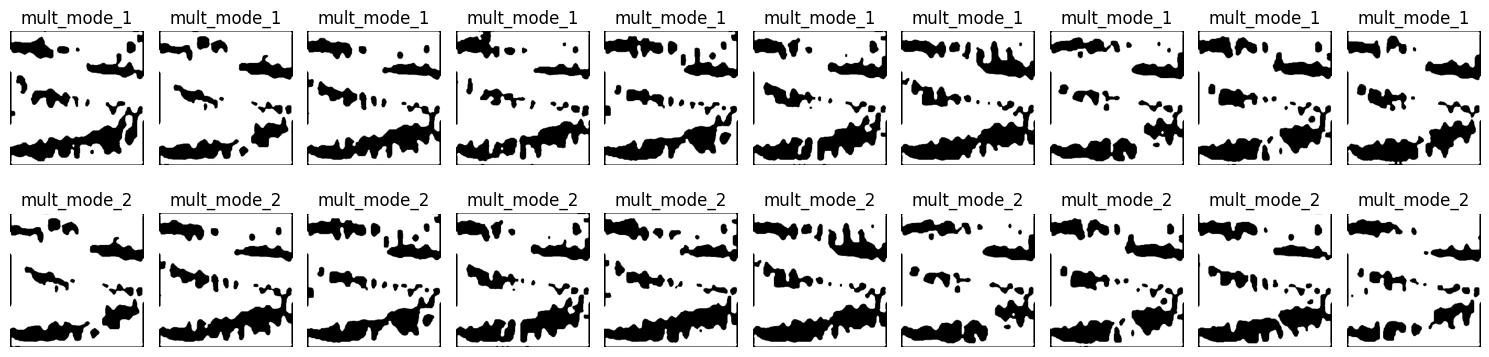

In [178]:
import matplotlib.pyplot as plt

def show_first_n_images_per_class(x_data, y_data, class_mapping, n=10):
    """
    Displays the first 'n' images for each class.
    
    Parameters:
    - x_data: NumPy array of images
    - y_data: NumPy array of labels
    - class_mapping: Dictionary mapping class names to labels
    - n: Number of images per class to display
    """
    unique_classes = np.unique(y_data)
    
    plt.figure(figsize=(15, len(unique_classes) * 2))
    
    for i, class_label in enumerate(unique_classes):
        class_indices = np.where(y_data == class_label)[0][:n]  # Get first 'n' indices for the class
        class_name = [k for k, v in class_mapping.items() if v == class_label][0]  # Get class name

        for j, idx in enumerate(class_indices):
            plt.subplot(len(unique_classes), n, i * n + j + 1)
            plt.imshow(x_data[idx].squeeze(), cmap='gray')  # Display grayscale image
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call function to display images
show_first_n_images_per_class(x_data, y_data, class_mapping, n=10)


### Define CNN Model Architecture

In [179]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, SpatialDropout2D
# from keras.regularizers import l2
# from keras.callbacks import ReduceLROnPlateau

# model = Sequential()

# # Convolutional layers
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1), kernel_regularizer=l2(0.01)))
# model.add(MaxPooling2D(2, 2))
# model.add(BatchNormalization())  # Move BatchNormalization AFTER MaxPooling2D()
# model.add(SpatialDropout2D(0.3))

# model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
# model.add(MaxPooling2D(2, 2))
# model.add(BatchNormalization())

# model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
# model.add(MaxPooling2D(2, 2))
# model.add(BatchNormalization())

# # Global Average Pooling
# model.add(GlobalAveragePooling2D())

# # Fully connected layers
# model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))  # ✅ Change from 3 to 1 for binary classification

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # ✅ Use binary_crossentropy

# # Learning rate scheduler
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# # Display the model architecture
# model.summary()



### New Model Architecture

In [180]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.regularizers import l2

model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 1), kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

# Additional Layer for More Feature Extraction
# model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.01)))  # ✅ NEW LAYER
# model.add(MaxPooling2D(2,2))
# model.add(BatchNormalization())

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Fully connected layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # ✅ Increased neurons
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/Users/nayanthara/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_100 (Conv2D)             │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 127, 127, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_19            │ (None, 127, 127, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 62, 62, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (None, 30, 30, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,209 (430.50 KB)

 Trainable params: 109,761 (428.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [181]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.regularizers import l2

model = Sequential()

# ✅ More Layers for Better Feature Extraction
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 1), kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

# ✅ Add more convolutional layers
model.add(Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

model.add(Conv2D(512, (3,3), activation='relu', kernel_regularizer=l2(0.01)))  # New layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

# ✅ Global Average Pooling instead of Flatten
model.add(GlobalAveragePooling2D())

# ✅ Fully connected layers
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))  
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# ✅ Compile Model with Lower Learning Rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # ✅ Lower learning rate
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_103 (Conv2D)             │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (None, 127, 127, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_20            │ (None, 127, 127, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (None, 62, 62, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_105               │ (None, 30, 30, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (None, 14, 14, 256)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 6, 6, 512)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 512)            │             

 Total params: 1,835,137 (7.00 MB)

 Trainable params: 1,833,153 (6.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

### Load Dataset for Training

In [182]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Stronger Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=45,   # ✅ Increased rotation (more variability)
    width_shift_range=0.4,  # ✅ Increased horizontal shift
    height_shift_range=0.4,  # ✅ Increased vertical shift
    shear_range=0.4,  # ✅ Stronger shearing effect
    zoom_range=0.5,  # ✅ More aggressive zoom
    brightness_range=[0.7, 1.3],  # ✅ Adjust brightness randomly
    horizontal_flip=True,  # ✅ Flip images horizontally
    vertical_flip=True,  # ✅ Flip images vertically (if logical for your dataset)
    fill_mode="nearest",  # ✅ Fill missing pixels after transformations
    validation_split=0.25  # ✅ Keep 25% of data for validation
)

# Load Training Data
train_ds = datagen.flow_from_directory(
    "Data-new/train",
    target_size=(256, 256),
    color_mode="grayscale",
    batch_size=16,  # ✅ Reduce batch size to fit small dataset
    class_mode="binary",
    subset="training"
)

# Load Validation Data
val_ds = datagen.flow_from_directory(
    "Data-new/val",  # ✅ Should be the same parent directory
    target_size=(256, 256),
    color_mode="grayscale",
    batch_size=16,
    class_mode="binary",
    subset="validation"
)

# ✅ Data Augmentation (Only for x_train)
datagen = ImageDataGenerator(
    rotation_range=45,  
    width_shift_range=0.4,  
    height_shift_range=0.4,  
    shear_range=0.4,  
    zoom_range=0.5,  
    brightness_range=[0.7, 1.3],  
    horizontal_flip=True,  
    vertical_flip=True,  
    fill_mode="nearest"  
)

# ✅ Apply Augmentation on Training Data
train_ds = datagen.flow(x_train, y_train)

# ✅ Validation Data (No Augmentation)
val_ds = (x_test, y_test)


Found 252 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


### Train Model

In [183]:
# ✅ Keep One-Hot Encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# ✅ Modify Model Output Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    # Your convolutional layers...
    
    Dense(2, activation='softmax')  # ✅ Use 2 neurons for 2 classes (One-Hot Output)
])

# ✅ Compile with `categorical_crossentropy`
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train Model
hist = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=7
)


Epoch 1/7


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 2), output.shape=(None, 256, 256, 2)

In [152]:
from tensorflow.keras.utils import to_categorical

# ✅ Convert labels to one-hot encoding (ONLY if using `softmax`)
# If using `sigmoid`, comment this out
# y_train = to_categorical(y_train, num_classes=2)
# y_test = to_categorical(y_test, num_classes=2)

# ✅ Check the shape of y_train and y_test
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# ✅ Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=5,
    verbose=1
)

# ✅ Evaluate Model on Test Set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

# ✅ Print Training & Testing Results
print("\n🔹 Model Training Complete!")
print(f"✅ Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"✅ Training Loss: {history.history['loss'][-1]:.4f}")
print(f"✅ Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"✅ Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


y_train shape: (335,)
y_test shape: (84,)
Epoch 1/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.5288 - loss: 1.1684 - val_accuracy: 0.5357 - val_loss: 1.0609
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.5893 - loss: 1.0321 - val_accuracy: 0.5357 - val_loss: 0.9788
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.4766 - loss: 0.9721 - val_accuracy: 0.5357 - val_loss: 0.9120
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.5349 - loss: 0.9081 - val_accuracy: 0.4643 - val_loss: 0.8688
Epoch 5/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.4756 - loss: 0.8650 - val_accuracy: 0.4643 - val_loss: 0.8483
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4431 - loss: 0.8526

🔹 Model Training Complete!
✅ Training Accuracy: 0.4955
✅ Training Loss: 0.8540
✅ Validation Accuracy: 0.4643
✅ Validation Loss: 0.8483
✅ Test Accuracy: 0.4643
✅ Test Loss: 0.8483


In [149]:
""" # Train the model using flow_from_directory data
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Learning rate scheduler & early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    train_ds,                  # Training dataset
    validation_data=val_ds,     # Validation dataset
    batch_size=10,              # Defined in dataset loading
    epochs=20,                  # Fine-tuning doesn't need too many epochs
    callbacks=[reduce_lr, early_stopping],  # Learning rate scheduler & early stopping
    verbose=1
)

# Evaluate Model Performance
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Accuracy: {test_acc:.4f}")
 """

' # Train the model using flow_from_directory data\nfrom tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping\n\n# Learning rate scheduler & early stopping\nreduce_lr = ReduceLROnPlateau(monitor=\'val_loss\', factor=0.5, patience=3, min_lr=1e-6)\nearly_stopping = EarlyStopping(monitor=\'val_loss\', patience=5, restore_best_weights=True)\n\n# Train the Model\nhistory = model.fit(\n    train_ds,                  # Training dataset\n    validation_data=val_ds,     # Validation dataset\n    batch_size=10,              # Defined in dataset loading\n    epochs=20,                  # Fine-tuning doesn\'t need too many epochs\n    callbacks=[reduce_lr, early_stopping],  # Learning rate scheduler & early stopping\n    verbose=1\n)\n\n# Evaluate Model Performance\ntest_loss, test_acc = model.evaluate(val_ds)\nprint(f"Test Accuracy: {test_acc:.4f}")\n '

#### Optional: Add a Learning Rate Scheduler

In [79]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model with the scheduler
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[reduce_lr]  # Helps adjust learning rate dynamically
)


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.5164 - loss: 0.7374 - val_accuracy: 0.5422 - val_loss: 0.7304 - learning_rate: 0.0010
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 359ms/step - accuracy: 0.5108 - loss: 0.7280 - val_accuracy: 0.5422 - val_loss: 0.7885 - learning_rate: 0.0010
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.5120 - loss: 0.7366 - val_accuracy: 0.5422 - val_loss: 0.7329 - learning_rate: 0.0010
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.4929 - loss: 0.7271 - val_accuracy: 0.5422 - val_loss: 0.7297 - learning_rate: 0.0010
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.5552 - loss: 0.7197 - val_accuracy: 0.5422 - val_loss: 0.7314 - learning_rate: 0.0010
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.5244 - loss: 0.7249 - val_accuracy: 0.4699 - val_loss: 0.7324 - learning_rate: 0.0010
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.5087 - loss: 0.7428 - 

### Evaluate and Test Model

In [151]:
# Evaluate on validation set
test_loss, test_acc = model.evaluate(validation_data)
print(f"Test Accuracy: {test_acc:.4f}")


NameError: name 'validation_data' is not defined

### Plot Training Curves

NameError: name 'val_acc' is not defined

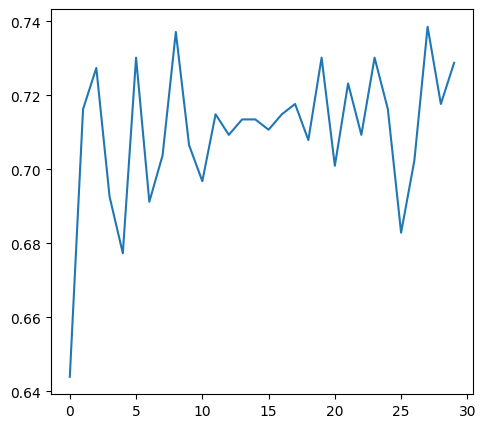

In [39]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training & validation accuracy and loss curves.
    """
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.show()

# Call function to visualize training results
plot_training_history(history)


### Evaluate Model Performance

In [40]:
# Evaluate on validation set
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Accuracy: {test_acc:.4f}")

ValueError: math domain error

NameError: name 'val_acc' is not defined

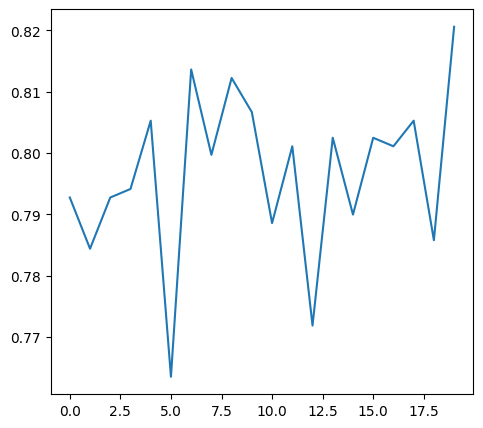

In [30]:
# Plot accuracy and loss curves
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to visualize training
plot_history(history)


In [42]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load an image for prediction
img_path = val_ds  # Change this to your test image path
img = image.load_img(img_path, target_size=(256, 256), color_mode="grayscale")
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize

# Predict
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
print(f"Predicted Class: {train_ds.class_names[predicted_class]}")


TypeError: path should be path-like or io.BytesIO, not <class 'tensorflow.python.data.ops.skip_op._SkipDataset'>